# La finalidad es poder encontrar la mayor relación entre las caracteristicas que nos suministra el cliente, para poder modelar un algoritmo de predicción del precio de la poliza de seguro.

    1. Lectura y limpieza de datos.
    2. Explorar las caracteristicas.
    2. Análisis de las variables.
    4. Identificar relación entre variables.
    5. División de datos.
    6. Construcción del Modelo.
    7. Evaluación del modelo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
import scipy.stats as stats


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")

In [3]:
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [6]:
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.56
581,19,male,30.59,0,no,northwest,1639.56


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### En esta etapa pudimos verificar:
    * Cantidad de columnas y filas.
    * Existencia de duplicados y eliminar el mismo.
    * No existen valores faltantes.
    * Tipo de columnas.

## Grafica de variables, visualizar distribución de las variables.

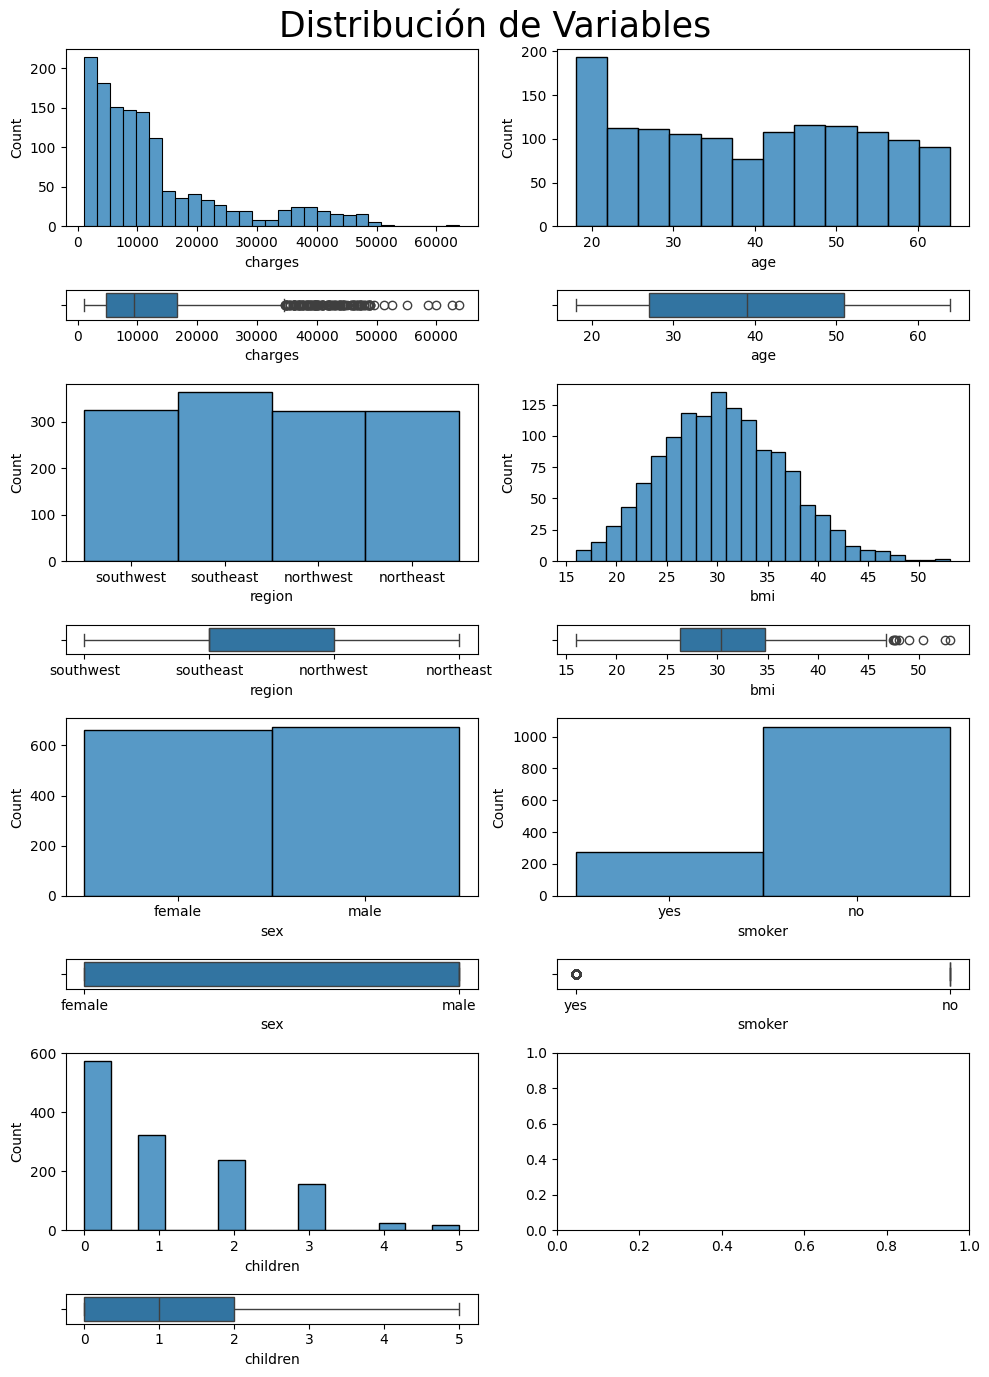

In [9]:
fig, axis = plt.subplots(8,2, figsize= (10,14), gridspec_kw={"height_ratios": [6, 1, 6, 1, 6, 1, 6, 1]})

sns.histplot(ax= axis[0,0], data = df, x = "charges" )
sns.boxplot( ax = axis[1,0], data = df, x= "charges")

sns.histplot(ax= axis[0,1], data = df, x = "age" )
sns.boxplot( ax = axis[1,1], data = df, x= "age")

sns.histplot(ax= axis[2,0], data = df, x = "region" )
sns.boxplot( ax = axis[3,0], data = df, x= "region")

sns.histplot(ax= axis[2,1], data = df, x = "bmi" )
sns.boxplot( ax = axis[3,1], data = df, x= "bmi")

sns.histplot(ax= axis[4,0], data = df, x = "sex" )
sns.boxplot( ax = axis[5,0], data = df, x= "sex")

sns.histplot(ax= axis[4,1], data = df, x = "smoker" )
sns.boxplot( ax = axis[5,1], data = df, x= "smoker")

sns.histplot(ax= axis[6,0], data = df, x = "children" )
sns.boxplot( ax = axis[7,0], data = df, x= "children")

fig.delaxes(axis[7, 1])


plt.suptitle("Distribución de Variables", size=25)

plt.tight_layout()
plt.show()

### Verificando las variables por separado, podemos observar :

    1- La mayoria de polizas son inferiores al valor de 20.000$.
    2- El rango de edades tiene mayor incidencia de 20 - 30 años.
    3- La región tiene una diferencia muy pequeña, siendo el sureste quien tiene mas precencia.
    4- el BMI tiene la mayor presencia entre 25-35, esto indica que la mayoria de los asegurados, tiene sobrepeso, debido a que un nivel normal es hasta 18.5

### Procedemos convertir las variables categoricas en variables indicadoras, para concatenarlas con un la data que solo es numerica, de esa manera podemos trabajar con el conjunto de datos de manera mas comoda.

In [10]:
df_nm = pd.get_dummies(df[["sex", "smoker", "region"]], drop_first=True)
df_ap = df.select_dtypes(exclude=('object','category'))
carga = [df_ap,df_nm.astype(int)]
data = pd.concat(carga, axis=1)

## Validamos los valores anomalos

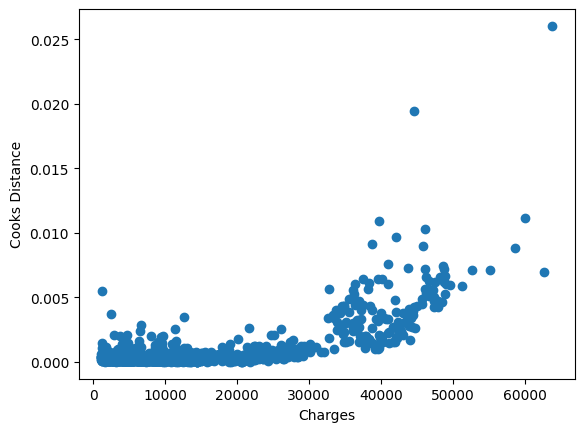

In [11]:
X = df_ap.drop('charges', axis=1)
y = df_ap['charges']

X = sm.add_constant(X)


modelo = sm.OLS(y, X).fit()

influencia = modelo.get_influence()
distancia_cook = influencia.cooks_distance

plt.scatter(df_ap.charges, distancia_cook[0])
plt.xlabel('Charges')
plt.ylabel('Cooks Distance')
plt.show()

In [12]:
np.where(distancia_cook[0]>0.005)

(array([  14,   34,   39,  109,  128,  161,  175,  185,  263,  265,  281,
         292,  377,  420,  421,  488,  530,  543,  549,  577,  620,  673,
         676,  724,  758,  802,  818,  859,  882,  900,  950, 1046, 1061,
        1121, 1123, 1145, 1155, 1185, 1229, 1239, 1240, 1287, 1299, 1300,
        1316]),)

In [13]:
indices = [14, 34, 39, 109, 128, 161, 175, 185, 263, 265, 281, 292, 377, 420, 421, 488, 530, 543, 549, 577, 620, 673, 676, 724, 758, 802, 818, 859, 882, 900, 950, 1046, 1061, 1121, 1123, 1145, 1155, 1185, 1229, 1239, 1240, 1287, 1299, 1300, 1316]

df.iloc[indices].head(1)

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.13,0,yes,southeast,39611.76


### Todos los casos anomalos, podemos observar que tienen algo en comun. 

        * Son personas fumadoras casi en su totalidad.
        * Tienen problema de sobrepeso.
        
Consideramos que son datos que se deben quedar, porque aportaran informacion importante al modelo.
        

### Correlación entre las variables.

In [14]:
df_corr = data.corr()
df_corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.00,0.11,0.04,0.30,-0.02,-0.03,0.00,-0.01,0.01
bmi,0.11,1.00,0.01,0.20,0.05,0.00,-0.14,0.27,-0.01
children,0.04,0.01,1.00,0.07,0.02,0.01,0.03,-0.02,0.02
charges,0.30,0.20,0.07,1.00,0.06,0.79,-0.04,0.07,-0.04
sex_male,-0.02,0.05,0.02,0.06,1.00,0.08,-0.01,0.02,-0.00
smoker_yes,-0.03,0.00,0.01,0.79,0.08,1.00,-0.04,0.07,-0.04
region_northwest,0.00,-0.14,0.03,-0.04,-0.01,-0.04,1.00,-0.35,-0.32
region_southeast,-0.01,0.27,-0.02,0.07,0.02,0.07,-0.35,1.00,-0.35
region_southwest,0.01,-0.01,0.02,-0.04,-0.00,-0.04,-0.32,-0.35,1.00


## Es notorio que el valor de la prima es influenciado por 3 caracteristicas principalmente.
    1- Fumador.
    2- Edad.
    3- Indice de masa muscular.

        Las otras variables muestran una relación baja o casi nula.

In [15]:
dt_pro = data.drop(['children', 'region_northwest', 'region_southeast', 'region_southwest', 'sex_male'], axis=1)
dt_pro.head(5)

,age,bmi,charges,smoker_yes
0,19,27.90,16884.92,1
1,18,33.77,1725.55,0
2,28,33.00,4449.46,0
3,33,22.70,21984.47,0
4,32,28.88,3866.86,0


In [16]:
X = dt_pro.drop('charges', axis=1)
y = dt_pro['charges']

X = sm.add_constant(X)

modelo = sm.OLS(y, X)

results = modelo.fit()

In [17]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1314.
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:00:00   Log-Likelihood:                -13547.
No. Observations:                1337   AIC:                         2.710e+04
Df Residuals:                    1333   BIC:                         2.712e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.167e+04    938.136    -12.441      0.0

### Análisis: 

1- age: El coeficiente para la variable 'age' es 259.4312, lo que sugiere que, manteniendo todas las demás variables constantes, un aumento de una unidad en la edad se relaciona con un aumento de aproximadamente 259.43 en los cargos.

2- bmi: El coeficiente para 'bmi' es 322.6426, lo que indica que un incremento de una unidad en el índice de masa corporal (bmi) se asocia con un aumento de aproximadamente 322.64 en los cargos, manteniendo las otras variables constantes.

3- smoker: El coeficiente para la variable categórica 'smoker_yes' es significativamente alto (2.382e+04). Indica que, manteniendo las otras variables constantes, los fumadores tienden a tener cargos significativamente más altos que los no fumadores.

### Significancia estadística:
Los valores P (P>|t|) asociados a los coeficientes son todos muy bajos (0.000), lo que sugiere que todas las variables son estadísticamente significativas para predecir los cargos.

### Supuestos:

El valor de Durbin-Watson de 2.077 indica que puede haber autocorrelación residual. Este valor está cerca de 2, lo que sugiere una correlación moderada.

El valor Omnibus de 299.150 y el valor de Jarque-Bera de 707.824 indican que la distribución de los residuos puede no ser normal.

In [18]:
residuos = results.resid
residuos

0      -9196.49
1      -2168.16
2      -1790.12
3      17769.33
4      -2081.17
         ...   
1333    -691.56
1334   -1090.84
1335   -3257.61
1336     -92.59
1337   -8213.65
Length: 1337, dtype: float64

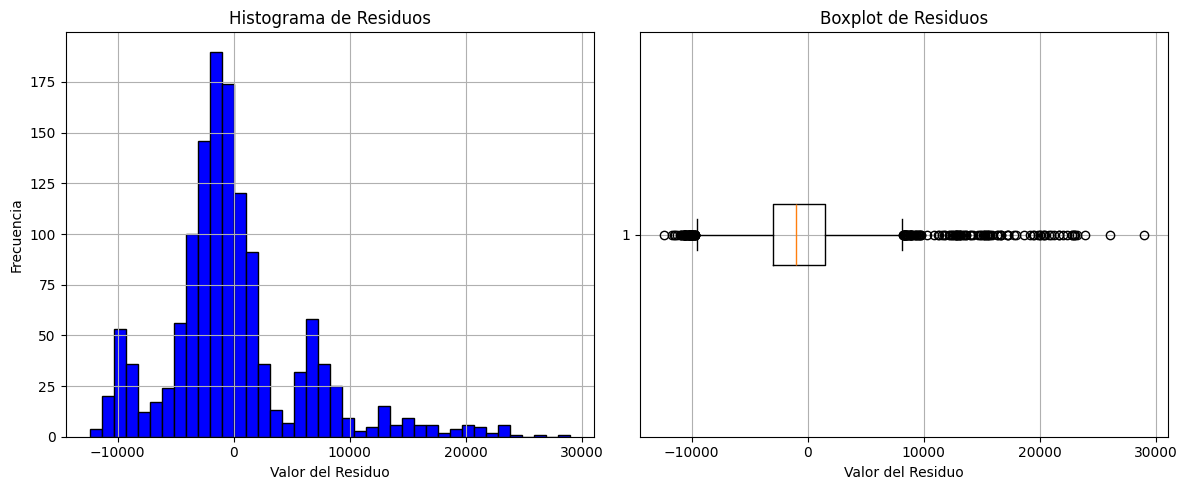

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Histograma de los residuos en el primer subgráfico (ax1)
ax1.hist(residuos, bins=40, color='blue', edgecolor='black')
ax1.set_title('Histograma de Residuos')
ax1.set_xlabel('Valor del Residuo')
ax1.set_ylabel('Frecuencia')
ax1.grid(True)

# Boxplot de los residuos en el segundo subgráfico (ax2)
ax2.boxplot(residuos, vert=False)
ax2.set_title('Boxplot de Residuos')
ax2.set_xlabel('Valor del Residuo')
ax2.grid(True)

# Muestra la figura con ambos gráficos
plt.tight_layout()  # Ajusta los márgenes para evitar superposiciones
plt.show()

In [20]:
print(f'Valor medio de los residuos: {residuos.mean()}')

Valor medio de los residuos: 1.735998862321999e-12


In [21]:
_, p_value = stats.shapiro(residuos)
p_value

2.8383262555135642e-28

El valor p (p-value) obtenido de la prueba de Shapiro-Wilk es extremadamente pequeño, específicamente 2.8383262555135642e-28. En la prueba de normalidad de Shapiro-Wilk, este valor indica la probabilidad de observar los datos si realmente provinieran de una distribución normal. Dado que el p-value es muy cercano a cero (más pequeño que 0.05, que es el umbral comúnmente utilizado), generalmente se interpretaría como evidencia significativa para rechazar la hipótesis nula de normalidad.

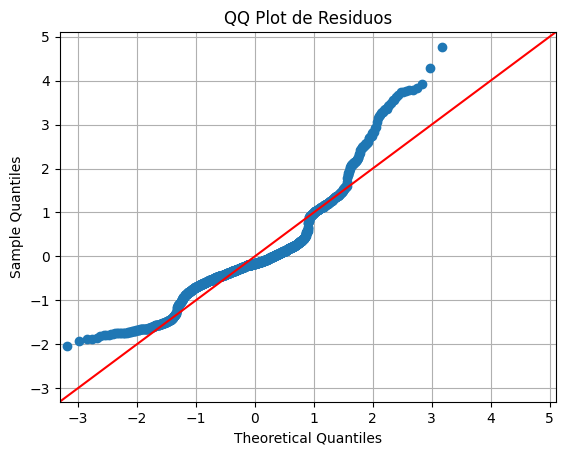

In [22]:
# Crea un QQ plot de los residuos
fig = sm.qqplot(residuos, line='45', fit=True)
plt.title('QQ Plot de Residuos')
plt.grid(True)
plt.show()

In [23]:
X = dt_pro.drop(['charges'], axis= 1)
y = dt_pro['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

  7%|▋         | 3/42 [00:00<00:01, 20.44it/s]

100%|██████████| 42/42 [00:02<00:00, 18.22it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 3
[LightGBM] [Info] Start training from score 13030.203373


In [25]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.90,0.90,4252.67,0.14
HistGradientBoostingRegressor,0.89,0.89,4414.33,0.16
LGBMRegressor,0.89,0.89,4483.61,0.18
KNeighborsRegressor,0.88,0.88,4747.84,0.01
RandomForestRegressor,0.87,0.87,4793.13,0.23
BaggingRegressor,0.87,0.87,4853.63,0.03
AdaBoostRegressor,0.87,0.87,4947.60,0.02
XGBRegressor,0.85,0.85,5285.54,0.10
ExtraTreesRegressor,0.84,0.84,5458.71,0.13


In [26]:
model = LGBMRegressor(n_estimators=100, learning_rate=0.1)

In [27]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 3
[LightGBM] [Info] Start training from score 13030.203373


In [28]:
from numpy import mean, std

puntuaciones = cross_val_score(model, X_train, y_train, cv=10)
print("Puntuaciones de validación cruzada: {}".format(puntuaciones))
print("Puntuación media de validación cruzada: {:.2f}".format(mean(puntuaciones)))
print("Desviación estándar de validación cruzada: {:.2f}".format(std(puntuaciones)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 962, number of used features: 3
[LightGBM] [Info] Start training from score 13011.457168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 962, number of used features: 3
[LightGBM] [Info] Start training from score 13022.466813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 962, number of used features: 3
[LightGBM] [Info] Start trainin

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 962, number of used features: 3
[LightGBM] [Info] Start training from score 13064.579680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 962, number of used features: 3
[LightGBM] [Info] Start training from score 13078.756788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 962, number of used features: 3
[LightGBM] [Info] Start trainin